# 이미지 분류 데이터 준비

In [ ]:
import os
import urllib.request
import zipfile

#data 폴더가 존재하지 않는 경우.. 만든다

data_dir = './data/'

if not os.path.exists(data_dir):
    
    os.mkdir(data_dir)

In [ ]:
#imageNet의 class index 다운
#keras 제공

url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

save_path = os.path.join(data_dir,'imagenet_class_index.json')

if not os.path.exists(save_path):
    
    urllib.request.urlretrieve(url,save_path)


In [ ]:
#pytorch 튜토리얼 제공
#개미와 벌의 이미지 데이터

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    
    urllib.request.urlretrieve(url,save_path)

    #zip파일 읽기
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir) #zip을 압축해제
    zip.close() #zip파일을 닫느다.

    #zip파일 삭제
    os.remove(save_path)

# 1. import package

사용할 패키지 가져오기

In [ ]:
import numpy as np

import json

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

#파이토치 버전
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)


PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


# 2. 사전학습한 vgg-16 불러오기

ImageNet으로 파라미터를 학습한 vgg-16 불러오기

In [ ]:
#학습된 VGG-16 모델 읽어오기
#처음 실행시에는, 학습된 파라미터를 다운로드해야해서, 시간이 좀 걸린다

##vgg-16 모델 인스턴스 생성

use_pretrained = True #학습된 파라미터 사용하겠다

net = models.vgg16(pretrained = use_pretrained)
net.eval() #추론모드(평가모드)

#모델의 네트워크 구성을 출력
print(net)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 3. 입력 이미지의 전처리 클래스

In [ ]:
#입력 이미지의 전처리 클래스

class BaseTransform():
    
    """
    이미지의 크기를 resize하고, 색상을 normalization한다.

    attributes
    -----------

    resize : int
        리사이즈 대상의 이미지 크기
    
    mean : (R,G,B)
        각 색상 채널의 평균
    
    std : (R,G,B)
        각 색상 채널의 표준편차
    
    """

    def __init__(self, resize, mean, std):
        
        self.base_transform = transforms.Compose([
            transforms.Resize(resize), #짧은 변의 길이가 resize 크기
            transforms.CenterCrop(resize), #이미지 중앙을 resize * resize로 자르기
            transforms.ToTensor(), #torch tensor로 변환
            transforms.Normalize(mean,std) #색상 정보의 표준화
        ])
    
    #인스턴스를 구체적인 함수를 지정하지 않고, 호출하면 실행시키는 매직 메소드
    def __call__(self, img):
        
        return self.base_transform(img)

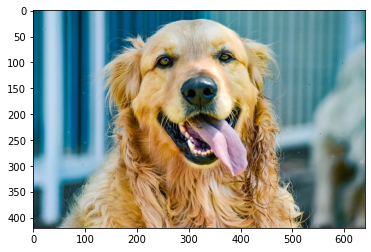

In [ ]:
#이미지 전처리 동작 확인하기

#1. 이미지 읽기

image_file_path = '/content/data/goldenretriever.jpg'
img = Image.open(image_file_path) #[높이][너비][RGB]

#2. 원본 이미지 표시
plt.imshow(img)
plt.show()

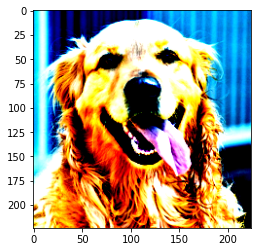

In [ ]:
#3. 전처리된 이미지 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = BaseTransform(resize,mean,std)

#인스턴스 이름으로 호출하면 __call__함수 실행
img_transformed = transform(img) #torch.Size([3,224,244])

#PIL 라이브러리는 [높이, 너비, 색상]으로 이미지를 다룸
#[색상, 높이, 너비]를 [높이, 너비, 색상]으로 변환하고 0-1로 값을 제한하여 표시
#그냥 넣으면 에러남

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

# 4. 출력 결과에서 라벨을 예측하는 후처리 클래스 작성

In [ ]:
#ILSVRC 라벨 정보를 읽어 사전형 변수를 생성

ILSVRC_class_index = json.load(open('/content/data/imagenet_class_index.json','r'))

ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [ ]:
#출력 결과에서 라벨을 예측하는 후처리 클래스

class ILSVRCPredictor():
    
    """
    ILSVRC 데이터에 대한 모델의 출력에서 라벨을 구함

    Attributes
    ---------------
    class_index : dictionary
           클래스 index와 라벨명을 대응시킨 사전형 변수
    
    """

    def __init__(self, class_index):
        
        self.class_index = class_index
    
    def predict_max(self, out):
        
        """
        최대 확률의 ILSVRC 라벨명 가져오기

        Parameters
        --------------

        out : torch.Size([1,1000])
            
            Net에서 출력
        
        Returns
        ---------------

        predicted_label_name : str
                가장 예측 확률이 높은 라벨명
        
        """

        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name

#5. 사전학습된 vgg모델로 이미지 예측

In [ ]:
#ILSVRC 라벨 정보를 읽어 사전형 변수 생성

ILSVRC_class_index = json.load(open('/content/data/imagenet_class_index.json','r'))

#ILSVRCPredictor 인스턴스
predictor = ILSVRCPredictor(ILSVRC_class_index)

#입력 이미지 읽기
image_file_path = '/content/data/goldenretriever.jpg'

img = Image.open(image_file_path) #[높이][너비][색]

#전처리 후에 배치 크기 차원 추가
#전처리 클래스
transform = BaseTransform(resize, mean, std)

img_transformed = transform(img) #torch.Size([3,224,224])

inputs = img_transformed.unsqueeze_(0) #torch.Size([1,3,224,224])

#모델에 입력하고, 모델 출력을 라벨로 변환함
out = net(inputs) #torch.Size([1,1000])
result = predictor.predict_max(out)

#예측 결과 출력
print("입력 이미지의 예측 결과: ", result)


입력 이미지의 예측 결과:  golden_retriever
